# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


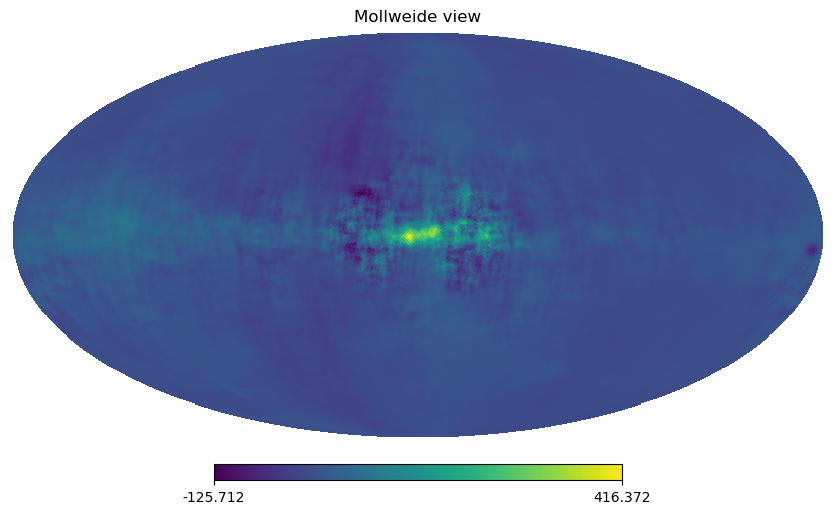

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v3/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'

MAC_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MAC_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MAC_obj.lmax+1))
c_ell_approx[0,MAC_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MAC_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MAC_obj.frequency_array, MAC_obj.number_components, pos_special_freqs=MAC_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MAC_obj.frequency_array, MAC_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MAC_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MAC_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MAC_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [6]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MAC_obj.lmin:,...]

In [7]:
# mixing_matrix_init = np.array([[1.,         1.,         0.        ],
#                                 [1.,         0.52387813, 0.00182426],
#                                 [1.,         0.3117258,  0.00324908],
#                                 [1.,         0.21971687, 0.00433627],
#                                 [1.,         0.15096497, 0.0057459 ],
#                                 [1.,         0.10631274, 0.0074421 ],
#                                 [1.,         0.07881344, 0.00935487],
#                                 [1.,         0.05159725, 0.0133358 ],
#                                 [1.,         0.03585547, 0.01906532],
#                                 [1.,         0.02552178, 0.02888587],
#                                 [1.,         0.0193825,  0.04508262],
#                                 [1.,         0.01493871, 0.08217483],
#                                 [1.,         0.01211497, 0.16061503],
#                                 [1.,         0.00871575, 0.37616284],
#                                 [1.,         0.,         1.        ]])

In [8]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [9]:
lmax = MAC_obj.lmax
n_iter = MAC_obj.n_iter
lmin = MAC_obj.lmin
nstokes = MAC_obj.nstokes
nside = MAC_obj.nside

In [10]:
number_frequencies = MAC_obj.number_frequencies
npix = MAC_obj.npix

def get_sampling_eta_v2b(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=jnp.empty(0), map_random_y=jnp.empty(0), suppress_low_modes=True):
        """ Solve sampling step 1 : sampling eta
            Solve CG for eta term with formulation : eta = C_approx^(-1/2) ( (E (B^t N^{-1} B)^{-1} B^t N^{-1/2}   x + C_approx^(1/2) y )

            Parameters
            ----------
            param_dict : dictionnary containing the following fields : nside, nstokes, lmax, number_frequencies
            
            red_cov_approx_matrix : correction covariance matrice (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]
            BtinvNB : matrices of noise combined with mixing matrices corresponding to (B^t N^{-1} B)^{-1}, dimension [component, component]
            # BtinvN_sqrt : matrices of noise combined with mixing matrices corresponding to B^T N^{-1/2}, dimension [component, frequencies]

            map_random_x : set of maps 0 with mean and variance 1/(pixel_size**2), which will be used to compute eta, default [] and it will be computed by the code ; dimension [nstokes, npix]
            map_random_y : set of maps 0 with mean and variance 1/(pixel_size**2), which will be used to compute eta, default [] and it will be computed by the code ; dimension [nstokes, npix]
            
            lmin : minimum multipole to be considered, default 0
            
            n_iter : number of iterations for harmonic computations, default 8

            limit_iter_cg : maximum number of iterations for the CG, default 1000
            tolerance : CG tolerance, default 10**(-12)

            initial_guess : initial guess for the CG, default [] (which is a covnention for its initialization to 0)

            Returns
            -------
            eta maps [nstokes, npix]
        """

        # assert red_cov_approx_matrix.shape[0] == param_dict['lmax'] + 1 - lmin
        # chx.assert_axis_dimension(red_cov_approx_matrix, 0, lmax + 1 - lmin)

        # Creation of the random maps if they are not given
        if jnp.size(map_random_x) == 0:
            print("Recalculating x !")
            # map_random_x = np.random.normal(loc=0, scale=1/jhp.nside2resol(nside), size=(number_frequencies,nstokes,npix))
            # map_random_x = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
            map_random_x = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))#/jhp.nside2resol(nside)
        if jnp.size(map_random_y) == 0:
            print("Recalculating y !")
            # map_random_y = np.random.normal(loc=0, scale=1/jhp.nside2resol(nside), size=(nstokes,npix))
            map_random_y = jax.random.normal(jax_key_PNRG, shape=(nstokes,npix))/jhp.nside2resol(nside)

        # Computation of the right hand side member of the CG
        red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)
        red_cov_approx_matrix_sqrt_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))
        
        # First right member : C_approx^(1/2) (E (B^t N^{-1} B)^{-1} E^t)^{-1} C_approx^(1/2) x    
        # first_member = map_random_x.reshape((param_dict["nstokes"],12*param_dict["nside"]**2))/(BtinvNB[0,0])
        # first_member = jnp.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN_sqrt, map_random_x)[0]/BtinvNB[0,0] # Selecting CMB component of the random variable
        first_member = jnp.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN_sqrt, map_random_x)[0]/BtinvNB[0,0]/hp.nside2resol(nside)**2 # Selecting CMB component of the random variable

        if suppress_low_modes:
            covariance_unity = jnp.zeros((lmax+1-lmin,nstokes,nstokes))
            # covariance_unity = covariance_unity.at[lmin:,...].set(jnp.eye(nstokes))
            covariance_unity = covariance_unity.at[:,...].set(jnp.eye(nstokes))
            first_member = micmac.maps_x_red_covariance_cell_JAX(jnp.copy(first_member), covariance_unity, nside=nside, lmin=lmin, n_iter=n_iter)

        second_member = micmac.maps_x_red_covariance_cell_JAX(map_random_y, jnp.linalg.pinv(red_cov_approx_matrix_sqrt), nside=nside, lmin=lmin, n_iter=n_iter)
        # second_member = micmac.maps_x_red_covariance_cell_JAX(map_random_y, jnp.linalg.pinv(red_cov_approx_matrix_sqrt_sqrt), nside=nside, lmin=lmin, n_iter=n_iter)
        
        map_solution_0 = first_member + second_member
        # map_solution_0 = second_member
        # return map_solution_0
        map_solution = micmac.maps_x_red_covariance_cell_JAX(map_solution_0.reshape((nstokes,npix)), red_cov_approx_matrix_sqrt, nside=nside, lmin=lmin, n_iter=n_iter)

        # if suppress_low_modes:
        #     map_solution = maps_x_red_covariance_cell_JAX(jnp.copy(map_solution), covariance_unity, nside=nside, lmin=lmin, n_iter=n_iter)

        return map_solution
    

In [27]:
jax_key_PNRG = jax.random.PRNGKey(MAC_obj.seed+10)
jax_key_PNRG = jax.random.PRNGKey(MAC_obj.seed+20)


In [28]:
%%time

# eta_maps = np.zeros((number_frequencies, nstokes, npix))
# eta_maps = np.zeros((nstokes, npix))
# map_random_x = []
# map_random_y = []
# eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
# eta_maps = micmac.get_sampling_eta_v2(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, lmin=lmin, n_iter=n_iter)

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
# eta_maps = MAC_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
eta_maps = get_sampling_eta_v2b(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 2.08 s, sys: 237 ms, total: 2.31 s
Wall time: 1.77 s


In [29]:
# jitted_sampling_eta = jax.jit(MAC_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [30]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [31]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [32]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [33]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [34]:
jax_key_PNRG = jax.random.PRNGKey(MAC_obj.seed+100)
new_eta_maps = get_sampling_eta_v2b(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG+1, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
old_eta_maps = np.copy(eta_maps)

Recalculating x !
Recalculating y !


In [35]:
overrelaxation_param = -.89

eta_maps_overrel = old_eta_maps*overrelaxation_param + ((1-overrelaxation_param**2)**.5)*new_eta_maps
eta_maps_overrel_extended = np.vstack([np.zeros_like(eta_maps_overrel[0]), eta_maps_overrel])
c_ells_eta_overrel = hp.anafast(eta_maps_overrel_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [36]:
print(np.einsum('sp,sp',old_eta_maps,old_eta_maps)/((nstokes*npix)**2))
print(np.einsum('sp,sp',old_eta_maps,new_eta_maps)/((nstokes*npix)**2))
print(np.einsum('sp,sp',eta_maps_overrel,old_eta_maps)/((nstokes*npix)**2))

2.1611199059704047
-0.023795457211947233
-1.9342465054672873


In [37]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [38]:
# covariance_noise = np.zeros_like(c_ell_approx)
# # covariance_noise[:nstokes,lmin:] = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
# covariance_noise[:nstokes,lmin:] = BtinvNB[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MAC_obj.lmax)[0,0,lmin:]

red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))


In [39]:
# analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(BtinvNB[0,0])

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

# analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
# analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix), red_cov_approx_matrix_sqrt)
# analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
# analytical_eta_term_cov = np.einsum('lij,ljk->lik', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cl_noise_harm))
# analytical_eta_term_cov = np.linalg.pinv(red_cl_noise_harm)
# analytical_eta_term_cov = red_cl_noise_harm
# analytical_eta_term_cov = np.linalg.pinv(red_cov_approx_matrix)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

In [40]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

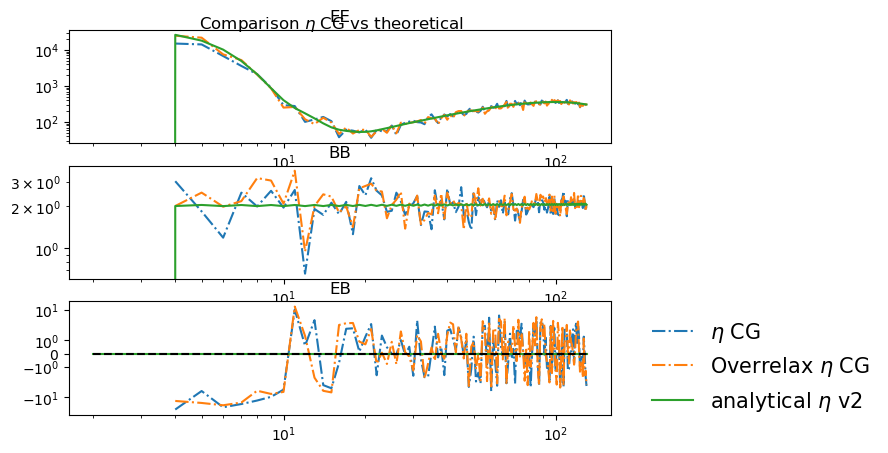

In [41]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:], '-.', label=r"Overrelax $\eta$ CG")
    
    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

In [42]:
# red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)